### **Features extraction (manual)**
### **Automatic classification of works of art**

---

### **Imports**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import cv2
from sklearn.preprocessing import normalize
from skimage import feature, io, color, filters
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from skimage.transform import resize
from scipy.fftpack import fft
import pywt

In [7]:
root = "../data/"
vasarely = root+"vasarely-victor-vasarely_1906/"

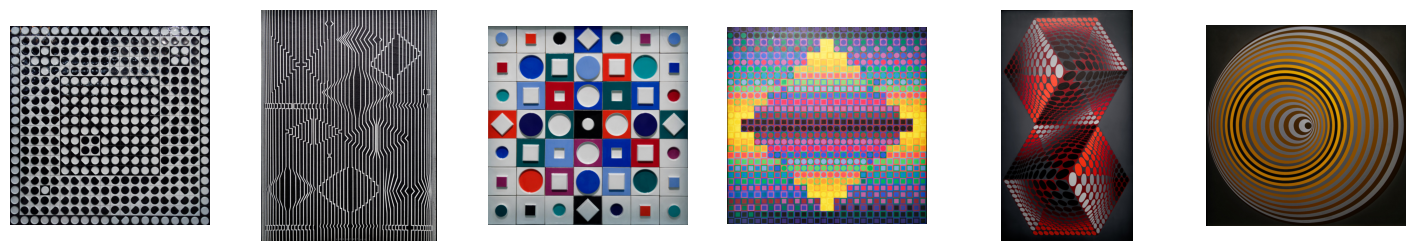

In [8]:
image_files = [os.path.join(vasarely, file) for file in os.listdir(vasarely) if file.endswith(('png', 'jpg', 'jpeg'))]
selected_images = image_files[:6]

fig, axes = plt.subplots(1, 6, figsize=(18, 3))
for ax, img_path in zip(axes, selected_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off') 
plt.show()

---

### **Features extraction**

#### **1- Colors based**

In [9]:
def color_histogram(image, bins=256):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist


def color_statistics(image):
    rgb_mean_std = [(np.mean(image[:, :, i]), np.std(image[:, :, i])) for i in range(3)]
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_mean_std = [(np.mean(hsv_image[:, :, i]), np.std(hsv_image[:, :, i])) for i in range(3)]
    
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    lab_mean_std = [(np.mean(lab_image[:, :, i]), np.std(lab_image[:, :, i])) for i in range(3)]
    
    return rgb_mean_std, hsv_mean_std, lab_mean_std

#### **2- Textures based**

In [14]:
def gabor_features(image, frequencies=(0.6, 1.0), thetas=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    features = []
    for frequency in frequencies:
        for theta in thetas:
            real, imag = gabor(image, frequency=frequency, theta=theta)
            features.append(real.mean())
            features.append(real.var())
    return features

def wavelet_features(image, wavelet='db1', level=2):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    features = []
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            for arr in coeff:
                features.append(arr.mean())
                features.append(arr.var())
        else:
            features.append(coeff.mean())
            features.append(coeff.var())
    return features

def glcm_features(image, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)
    features = []
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in properties:
        for angle in angles:
            for distance in distances:
                features.append(graycoprops(glcm, prop)[distances.index(distance), angles.index(angle)])
    return features

#### **3- Shapes and contours based**

In [15]:
def contour_features(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features = []
    for contour in contours:
        coeffs = fft(contour)
        features.append(np.mean(np.abs(coeffs)))
        features.append(np.var(np.abs(coeffs)))
    return features

def hog_features(image):
    hog_desc, hog_image = feature.hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
    return hog_desc

def hu_moments(image):
    moments = cv2.moments(image)
    huMoments = cv2.HuMoments(moments)
    return huMoments.flatten()

#### **4- Gradients, hues, luminances**

In [17]:
def perceptual_descriptors(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_hist = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    dominant_hue = np.argmax(hue_hist)
    mean_saturation = np.mean(hsv_image[:, :, 1])
    mean_luminance = np.mean(hsv_image[:, :, 2])
    
    return dominant_hue, mean_saturation, mean_luminance

# Fonction pour calculer les gradients de luminance et les contrastes locaux
def luminance_contrast_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    mean_gradient_magnitude = np.mean(gradient_magnitude)
    
    # Calculer le contraste local (écart-type de la luminance)
    local_contrast = filters.rank.standard_deviation(gray_image, selem=np.ones((5, 5)))
    mean_local_contrast = np.mean(local_contrast)
    
    return mean_gradient_magnitude, mean_local_contrast

#### **Dataframe of features**

In [ ]:
image_files = [os.path.join(vasarely, file) for file in os.listdir(vasarely) if file.endswith(('png', 'jpg', 'jpeg', 'bmp'))]

features = []

for img_path in image_files:
    image = cv2.imread(img_path)
    
    hist = color_histogram(image)
    
    rgb_stats, hsv_stats, lab_stats = color_statistics(image)
    

    # Combiner toutes les caractéristiques
    image_features = {
        'path': img_path,
        'histogram': hist,
        'rgb_mean_std': rgb_stats,
        'hsv_mean_std': hsv_stats,
        'lab_mean_std': lab_stats,
    }
    
    features.append(image_features)

print(features[0])